<a href="https://colab.research.google.com/github/jing-pw/YCBS258-Assignments/blob/master/C7_Exercises_Final_JW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from keras.layers import Dropout, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam, RMSprop, SGD, Adagrad
from keras.layers.pooling import MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import backend as K

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer

Using TensorFlow backend.


In [0]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

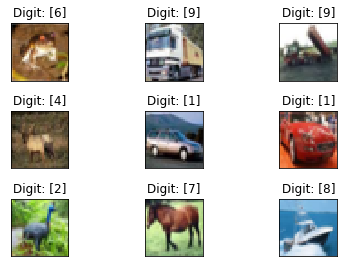

In [3]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], interpolation='none')
  plt.title("Digit: {}".format(Y_train[i]))
  plt.xticks([])
  plt.yticks([])

# Exercise
1. Create a list for each of the hyperparameters you want to search in
2. Create a loop or class that does a random search
3. Show the model parameters that gave you the best model

I would use the 6-layered CNN model created from the previous homework as the base model, which had obtained about 84% of accuracy, for further improvement.

First, I will use random search to determine a few hyperparameters. There are many hyperparameters can be tuned, ie. number of convolution layers, pooling layers, pooling methods, strides, kernal sizes, number of filters, learning rate, optimizer, dropout rate, use batchnorm or not etc etc.

Due to time constraint, I choose to tune following parameters
- kernal initializer
- activation function
- dropout
- optimizer

Kernal initializer returned errors upon fitting to the data, looks like the wrapper class in sklearn doesn't support this keyword. Therefore I removed it from the tuning list and used the default one.

To speed up training, I used large batch size.

If the time permits, I may implement the loop with np.random.choice and model evaluation scores to perform the hyperparameter tuning, using sklearn wrapper class and RandomizedSearchCV just to save some time.

In [4]:
X_train.dtype

dtype('uint8')

In [5]:
X_train.shape

(50000, 32, 32, 3)

Prepare data - convert to float32 then scale to (0,1)

In [0]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [7]:
np.max(X_train)

1.0

Encoding labels to categorical data

In [0]:
num_classes = 10
Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)

In [9]:
input_shape = X_train.shape[1:]
input_shape

(32, 32, 3)

In [16]:
#define parameter grid for the search

activation = ['relu', 'elu', 'tanh']
#initializer = ['glorot_uniform', 'he_uniform']
dropout = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
optimizer = ['adam', 'adagrad', 'rmsprop', 'sgd']

params = dict(
    actv=activation,
#    kinit=initializer,
    do=dropout,
    opt=optimizer
)
params

{'actv': ['relu', 'elu', 'tanh'],
 'do': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
 'opt': ['adam', 'adagrad', 'rmsprop', 'sgd']}

In [11]:
weight_decay = 5*1e-4
weight_decay

0.0005

In [0]:
#create the model from hyperparameters passed in
def build_model(actv, do, opt):
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same',
  #                 kernel_initializer='he_uniform',
                   kernel_regularizer=regularizers.l2(weight_decay), 
                   input_shape=input_shape))
  model.add(Activation(actv))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', 
  #                 kernel_initializer='he_uniform',
                   kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation(actv))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  if do != 0:
    model.add(Dropout(do))

  model.add(Conv2D(64, (3,3), padding='same',
  #                 kernel_initializer='he_uniform',
                   kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation(actv))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same',
  #                 kernel_initializer='he_uniform',
                   kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation(actv))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  if do != 0:
    model.add(Dropout(do))

  model.add(Conv2D(128, (3,3), padding='same',
  #                 kernal_initializer='he_uniform',
                   kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation(actv))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same',
  #                 kernal_initializer='he_uniform',
                   kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation(actv))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  if do != 0:
    model.add(Dropout(do))

  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', 
                optimizer=opt, metrics=['accuracy'])

  return model

In [0]:
#model class to use in the scikit random search CV 
model = KerasClassifier(build_fn=build_model, epochs=10, 
                        batch_size=128, verbose=1)

In [0]:
grid = RandomizedSearchCV(estimator=model, cv=KFold(3), 
                        param_distributions=params, 
                        verbose=20, n_iter=10, n_jobs=1)

In [24]:
grid_result = grid.fit(X_train, Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] opt=adam, do=0.3, actv=tanh .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
W0628 03:30:35.257923 140390966249344 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0628 03:30:35.662396 140390966249344 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
33333/33333 [==============================] - 10s 306us/step - loss: 2.0530 - acc: 0.3832
Epoch 2/10
33333/33333 [==============================] - 5s 155us/step - loss: 1.5543 - acc: 0.5202
Epoch 3/10
33333/33333 [==============================] - 5s 155us/step - loss: 1.3421 - acc: 0.5913
Epoch 4/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.2175 - acc: 0.6379
Epoch 5/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.1389 - acc: 0.6671
Epoch 6/10
33333/33333 [==============================] - 5s 157us/step - loss: 1.0686 - acc: 0.6886
Epoch 7/10
33333/33333 [==============================] - 5s 157us/step - loss: 1.0056 - acc: 0.7123
Epoch 8/10
33333/33333 [==============================] - 5s 158us/step - loss: 0.9692 - acc: 0.7265
Epoch 9/10
33333/33333 [==============================] - 5s 159us/step - loss: 0.9361 - acc: 0.7380
Epoch 10/10
16667/16667 [==============================] - 1s 68us/step
[CV] ......... opt

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.0min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 7s 210us/step - loss: 2.0604 - acc: 0.3827
Epoch 2/10
33333/33333 [==============================] - 5s 163us/step - loss: 1.5331 - acc: 0.5309
Epoch 3/10
33333/33333 [==============================] - 5s 163us/step - loss: 1.3276 - acc: 0.5988
Epoch 4/10
33333/33333 [==============================] - 5s 163us/step - loss: 1.2090 - acc: 0.6398
Epoch 5/10
33333/33333 [==============================] - 5s 163us/step - loss: 1.1240 - acc: 0.6710
Epoch 6/10
33333/33333 [==============================] - 5s 162us/step - loss: 1.0588 - acc: 0.6949
Epoch 7/10
33333/33333 [==============================] - 5s 162us/step - loss: 0.9981 - acc: 0.7169
Epoch 8/10
33333/33333 [==============================] - 5s 162us/step - loss: 0.9604 - acc: 0.7293
Epoch 9/10
33333/33333 [==============================] - 5s 161us/step - loss: 0.9146 - acc: 0.7477
Epoch 10/10
16667/16667 [==============================] - 1s 80us/step
[CV] ......... opt=

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.0min remaining:    0.0s


Epoch 1/10
33334/33334 [==============================] - 7s 214us/step - loss: 2.0275 - acc: 0.3939
Epoch 2/10
33334/33334 [==============================] - 5s 159us/step - loss: 1.5541 - acc: 0.5261
Epoch 3/10
33334/33334 [==============================] - 5s 159us/step - loss: 1.3548 - acc: 0.5900
Epoch 4/10
33334/33334 [==============================] - 5s 160us/step - loss: 1.2287 - acc: 0.6345
Epoch 5/10
33334/33334 [==============================] - 5s 159us/step - loss: 1.1370 - acc: 0.6651
Epoch 6/10
33334/33334 [==============================] - 5s 159us/step - loss: 1.0820 - acc: 0.6843
Epoch 7/10
33334/33334 [==============================] - 5s 159us/step - loss: 1.0154 - acc: 0.7097
Epoch 8/10
33334/33334 [==============================] - 5s 160us/step - loss: 0.9728 - acc: 0.7225
Epoch 9/10
33334/33334 [==============================] - 5s 159us/step - loss: 0.9369 - acc: 0.7385
Epoch 10/10
16666/16666 [==============================] - 1s 81us/step
[CV] ......... opt=

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.0min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 7s 206us/step - loss: 2.1861 - acc: 0.3593
Epoch 2/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.6280 - acc: 0.5003
Epoch 3/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.4008 - acc: 0.5779
Epoch 4/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.2608 - acc: 0.6280
Epoch 5/10
33333/33333 [==============================] - 5s 157us/step - loss: 1.1654 - acc: 0.6604
Epoch 6/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.0897 - acc: 0.6879
Epoch 7/10
33333/33333 [==============================] - 5s 157us/step - loss: 1.0248 - acc: 0.7085
Epoch 8/10
33333/33333 [==============================] - 5s 157us/step - loss: 0.9796 - acc: 0.7245
Epoch 9/10
33333/33333 [==============================] - 5s 156us/step - loss: 0.9352 - acc: 0.7440
Epoch 10/10
16667/16667 [==============================] - 1s 84us/step
[CV] ...... opt=rms

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.0min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 7s 210us/step - loss: 2.1827 - acc: 0.3590
Epoch 2/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.6243 - acc: 0.5026
Epoch 3/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.3978 - acc: 0.5795
Epoch 4/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.2571 - acc: 0.6292
Epoch 5/10
33333/33333 [==============================] - 5s 155us/step - loss: 1.1513 - acc: 0.6659
Epoch 6/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.0809 - acc: 0.6898
Epoch 7/10
33333/33333 [==============================] - 5s 155us/step - loss: 1.0222 - acc: 0.7130
Epoch 8/10
33333/33333 [==============================] - 5s 156us/step - loss: 0.9705 - acc: 0.7292
Epoch 9/10
33333/33333 [==============================] - 5s 156us/step - loss: 0.9308 - acc: 0.7428
Epoch 10/10
16667/16667 [==============================] - 2s 93us/step
[CV] ...... opt=rms

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.9min remaining:    0.0s


Epoch 1/10
33334/33334 [==============================] - 7s 222us/step - loss: 2.1810 - acc: 0.3605
Epoch 2/10
33334/33334 [==============================] - 5s 157us/step - loss: 1.6230 - acc: 0.5061
Epoch 3/10
33334/33334 [==============================] - 5s 157us/step - loss: 1.3937 - acc: 0.5788
Epoch 4/10
33334/33334 [==============================] - 5s 158us/step - loss: 1.2676 - acc: 0.6222
Epoch 5/10
33334/33334 [==============================] - 5s 158us/step - loss: 1.1733 - acc: 0.6548
Epoch 6/10
33334/33334 [==============================] - 5s 159us/step - loss: 1.0947 - acc: 0.6817
Epoch 7/10
33334/33334 [==============================] - 5s 159us/step - loss: 1.0410 - acc: 0.7025
Epoch 8/10
33334/33334 [==============================] - 5s 158us/step - loss: 0.9904 - acc: 0.7211
Epoch 9/10
33334/33334 [==============================] - 5s 157us/step - loss: 0.9484 - acc: 0.7366
Epoch 10/10
16666/16666 [==============================] - 2s 99us/step
[CV] ...... opt=rms

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  5.9min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 7s 222us/step - loss: 2.4442 - acc: 0.3730
Epoch 2/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.6494 - acc: 0.5246
Epoch 3/10
33333/33333 [==============================] - 5s 157us/step - loss: 1.4577 - acc: 0.5816
Epoch 4/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.3330 - acc: 0.6207
Epoch 5/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.2591 - acc: 0.6441
Epoch 6/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.1909 - acc: 0.6651
Epoch 7/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.1266 - acc: 0.6832
Epoch 8/10
33333/33333 [==============================] - 5s 155us/step - loss: 1.0727 - acc: 0.6984
Epoch 9/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.0473 - acc: 0.7088
Epoch 10/10
16667/16667 [==============================] - 2s 100us/step
[CV] ....... opt=a

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.9min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 8s 227us/step - loss: 2.4650 - acc: 0.3629
Epoch 2/10
33333/33333 [==============================] - 5s 155us/step - loss: 1.6915 - acc: 0.5002
Epoch 3/10
33333/33333 [==============================] - 5s 157us/step - loss: 1.4890 - acc: 0.5657
Epoch 4/10
33333/33333 [==============================] - 5s 158us/step - loss: 1.3478 - acc: 0.6069
Epoch 5/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.2599 - acc: 0.6380
Epoch 6/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.1775 - acc: 0.6614
Epoch 7/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.1320 - acc: 0.6741
Epoch 8/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.0863 - acc: 0.6922
Epoch 9/10
33333/33333 [==============================] - 5s 155us/step - loss: 1.0412 - acc: 0.7031
Epoch 10/10
16667/16667 [==============================] - 2s 107us/step
[CV] ....... opt=a

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.9min remaining:    0.0s


Epoch 1/10
33334/33334 [==============================] - 8s 234us/step - loss: 2.4553 - acc: 0.3731
Epoch 2/10
33334/33334 [==============================] - 5s 155us/step - loss: 1.6348 - acc: 0.5148
Epoch 3/10
33334/33334 [==============================] - 5s 155us/step - loss: 1.4373 - acc: 0.5757
Epoch 4/10
33334/33334 [==============================] - 5s 156us/step - loss: 1.3019 - acc: 0.6135
Epoch 5/10
33334/33334 [==============================] - 5s 156us/step - loss: 1.2092 - acc: 0.6472
Epoch 6/10
33334/33334 [==============================] - 5s 156us/step - loss: 1.1329 - acc: 0.6687
Epoch 7/10
33334/33334 [==============================] - 5s 156us/step - loss: 1.0707 - acc: 0.6849
Epoch 8/10
33334/33334 [==============================] - 5s 156us/step - loss: 1.0261 - acc: 0.7021
Epoch 9/10
33334/33334 [==============================] - 5s 156us/step - loss: 0.9805 - acc: 0.7143
Epoch 10/10
16666/16666 [==============================] - 2s 113us/step
[CV] ....... opt=a

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.8min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 8s 243us/step - loss: 1.9147 - acc: 0.4745
Epoch 2/10
33333/33333 [==============================] - 5s 154us/step - loss: 1.2834 - acc: 0.6455
Epoch 3/10
33333/33333 [==============================] - 5s 154us/step - loss: 1.0616 - acc: 0.7184
Epoch 4/10
33333/33333 [==============================] - 5s 154us/step - loss: 0.9071 - acc: 0.7705
Epoch 5/10
33333/33333 [==============================] - 5s 154us/step - loss: 0.7470 - acc: 0.8130
Epoch 6/10
33333/33333 [==============================] - 5s 154us/step - loss: 0.5746 - acc: 0.8678
Epoch 7/10
33333/33333 [==============================] - 5s 154us/step - loss: 0.4462 - acc: 0.9183
Epoch 8/10
33333/33333 [==============================] - 5s 152us/step - loss: 0.3454 - acc: 0.9577
Epoch 9/10
33333/33333 [==============================] - 5s 148us/step - loss: 0.2724 - acc: 0.9842
Epoch 10/10
16667/16667 [==============================] - 2s 126us/step
[CV] ........ opt=

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  9.8min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 8s 247us/step - loss: 1.9541 - acc: 0.4723
Epoch 2/10
33333/33333 [==============================] - 5s 153us/step - loss: 1.2941 - acc: 0.6474
Epoch 3/10
33333/33333 [==============================] - 5s 153us/step - loss: 1.0655 - acc: 0.7217
Epoch 4/10
33333/33333 [==============================] - 5s 154us/step - loss: 0.9166 - acc: 0.7686
Epoch 5/10
33333/33333 [==============================] - 5s 155us/step - loss: 0.7262 - acc: 0.8228
Epoch 6/10
33333/33333 [==============================] - 5s 154us/step - loss: 0.5615 - acc: 0.8749
Epoch 7/10
33333/33333 [==============================] - 5s 154us/step - loss: 0.4324 - acc: 0.9269
Epoch 8/10
33333/33333 [==============================] - 5s 153us/step - loss: 0.3448 - acc: 0.9593
Epoch 9/10
33333/33333 [==============================] - 5s 154us/step - loss: 0.2781 - acc: 0.9831
Epoch 10/10
16667/16667 [==============================] - 2s 137us/step
[CV] ........ opt=

[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed: 10.8min remaining:    0.0s


Epoch 1/10
33334/33334 [==============================] - 8s 246us/step - loss: 1.9687 - acc: 0.4867
Epoch 2/10
33334/33334 [==============================] - 5s 150us/step - loss: 1.2440 - acc: 0.6571
Epoch 3/10
33334/33334 [==============================] - 5s 150us/step - loss: 1.0203 - acc: 0.7321
Epoch 4/10
33334/33334 [==============================] - 5s 150us/step - loss: 0.8278 - acc: 0.7789
Epoch 5/10
33334/33334 [==============================] - 5s 150us/step - loss: 0.6405 - acc: 0.8478
Epoch 6/10
33334/33334 [==============================] - 5s 151us/step - loss: 0.5103 - acc: 0.8969
Epoch 7/10
33334/33334 [==============================] - 5s 150us/step - loss: 0.4008 - acc: 0.9404
Epoch 8/10
33334/33334 [==============================] - 5s 151us/step - loss: 0.3145 - acc: 0.9724
Epoch 9/10
33334/33334 [==============================] - 5s 150us/step - loss: 0.2569 - acc: 0.9906
Epoch 10/10
16666/16666 [==============================] - 2s 138us/step
[CV] ........ opt=

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 11.8min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 9s 272us/step - loss: 1.9178 - acc: 0.4136
Epoch 2/10
33333/33333 [==============================] - 5s 160us/step - loss: 1.4510 - acc: 0.5574
Epoch 3/10
33333/33333 [==============================] - 5s 160us/step - loss: 1.2518 - acc: 0.6277
Epoch 4/10
33333/33333 [==============================] - 5s 161us/step - loss: 1.1296 - acc: 0.6702
Epoch 5/10
33333/33333 [==============================] - 5s 161us/step - loss: 1.0345 - acc: 0.7043
Epoch 6/10
33333/33333 [==============================] - 5s 163us/step - loss: 0.9624 - acc: 0.7290
Epoch 7/10
33333/33333 [==============================] - 5s 163us/step - loss: 0.9212 - acc: 0.7434
Epoch 8/10
33333/33333 [==============================] - 5s 161us/step - loss: 0.8709 - acc: 0.7613
Epoch 9/10
33333/33333 [==============================] - 5s 160us/step - loss: 0.8443 - acc: 0.7738
Epoch 10/10
16667/16667 [==============================] - 2s 134us/step
[CV] ......... opt

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed: 12.8min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 9s 283us/step - loss: 1.8994 - acc: 0.4238
Epoch 2/10
33333/33333 [==============================] - 5s 159us/step - loss: 1.4563 - acc: 0.5558
Epoch 3/10
33333/33333 [==============================] - 5s 159us/step - loss: 1.2676 - acc: 0.6201
Epoch 4/10
33333/33333 [==============================] - 5s 160us/step - loss: 1.1455 - acc: 0.6675
Epoch 5/10
33333/33333 [==============================] - 5s 161us/step - loss: 1.0537 - acc: 0.6956
Epoch 6/10
33333/33333 [==============================] - 5s 161us/step - loss: 0.9741 - acc: 0.7252
Epoch 7/10
33333/33333 [==============================] - 5s 161us/step - loss: 0.9265 - acc: 0.7429
Epoch 8/10
33333/33333 [==============================] - 5s 162us/step - loss: 0.8811 - acc: 0.7577
Epoch 9/10
33333/33333 [==============================] - 5s 161us/step - loss: 0.8365 - acc: 0.7754
Epoch 10/10
16667/16667 [==============================] - 2s 147us/step
[CV] ......... opt

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 13.8min remaining:    0.0s


Epoch 1/10
33334/33334 [==============================] - 10s 299us/step - loss: 1.9168 - acc: 0.4128
Epoch 2/10
33334/33334 [==============================] - 5s 162us/step - loss: 1.4620 - acc: 0.5548
Epoch 3/10
33334/33334 [==============================] - 5s 162us/step - loss: 1.2763 - acc: 0.6177
Epoch 4/10
33334/33334 [==============================] - 5s 162us/step - loss: 1.1460 - acc: 0.6657
Epoch 5/10
33334/33334 [==============================] - 5s 162us/step - loss: 1.0495 - acc: 0.6977
Epoch 6/10
33334/33334 [==============================] - 5s 162us/step - loss: 0.9906 - acc: 0.7201
Epoch 7/10
33334/33334 [==============================] - 5s 163us/step - loss: 0.9319 - acc: 0.7396
Epoch 8/10
33334/33334 [==============================] - 5s 162us/step - loss: 0.8890 - acc: 0.7577
Epoch 9/10
33334/33334 [==============================] - 5s 162us/step - loss: 0.8518 - acc: 0.7701
Epoch 10/10
16666/16666 [==============================] - 3s 158us/step
[CV] ......... op

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 14.9min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 10s 292us/step - loss: 2.6906 - acc: 0.2891
Epoch 2/10
33333/33333 [==============================] - 5s 156us/step - loss: 2.0052 - acc: 0.3969
Epoch 3/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.8583 - acc: 0.4403
Epoch 4/10
33333/33333 [==============================] - 5s 157us/step - loss: 1.7917 - acc: 0.4628
Epoch 5/10
33333/33333 [==============================] - 5s 157us/step - loss: 1.7035 - acc: 0.4925
Epoch 6/10
33333/33333 [==============================] - 5s 158us/step - loss: 1.6657 - acc: 0.5050
Epoch 7/10
33333/33333 [==============================] - 5s 158us/step - loss: 1.6376 - acc: 0.5167
Epoch 8/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.5955 - acc: 0.5283
Epoch 9/10
33333/33333 [==============================] - 5s 157us/step - loss: 1.5760 - acc: 0.5388
Epoch 10/10
16667/16667 [==============================] - 3s 171us/step
[CV] .......... o

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed: 15.9min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 10s 290us/step - loss: 2.8471 - acc: 0.2876
Epoch 2/10
33333/33333 [==============================] - 5s 155us/step - loss: 2.0664 - acc: 0.3923
Epoch 3/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.8930 - acc: 0.4359
Epoch 4/10
33333/33333 [==============================] - 5s 155us/step - loss: 1.7690 - acc: 0.4699
Epoch 5/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.7150 - acc: 0.4929
Epoch 6/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.6649 - acc: 0.5095
Epoch 7/10
33333/33333 [==============================] - 5s 157us/step - loss: 1.5770 - acc: 0.5300
Epoch 8/10
33333/33333 [==============================] - 5s 155us/step - loss: 1.5394 - acc: 0.5443
Epoch 9/10
33333/33333 [==============================] - 5s 156us/step - loss: 1.5020 - acc: 0.5591
Epoch 10/10
16667/16667 [==============================] - 3s 173us/step
[CV] .......... o

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed: 17.0min remaining:    0.0s


Epoch 1/10
33334/33334 [==============================] - 10s 296us/step - loss: 2.7411 - acc: 0.2897
Epoch 2/10
33334/33334 [==============================] - 5s 155us/step - loss: 2.0176 - acc: 0.3881
Epoch 3/10
33334/33334 [==============================] - 5s 155us/step - loss: 1.8727 - acc: 0.4303
Epoch 4/10
33334/33334 [==============================] - 5s 156us/step - loss: 1.7908 - acc: 0.4621
Epoch 5/10
33334/33334 [==============================] - 5s 157us/step - loss: 1.7027 - acc: 0.4870
Epoch 6/10
33334/33334 [==============================] - 5s 157us/step - loss: 1.6559 - acc: 0.5012
Epoch 7/10
33334/33334 [==============================] - 5s 158us/step - loss: 1.6472 - acc: 0.5172
Epoch 8/10
33334/33334 [==============================] - 5s 156us/step - loss: 1.5790 - acc: 0.5349
Epoch 9/10
33334/33334 [==============================] - 5s 156us/step - loss: 1.5392 - acc: 0.5452
Epoch 10/10
16666/16666 [==============================] - 3s 180us/step
[CV] .......... o

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 18.0min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 11s 319us/step - loss: 2.4230 - acc: 0.3480
Epoch 2/10
33333/33333 [==============================] - 5s 163us/step - loss: 1.7329 - acc: 0.4756
Epoch 3/10
33333/33333 [==============================] - 5s 164us/step - loss: 1.4755 - acc: 0.5553
Epoch 4/10
33333/33333 [==============================] - 6s 165us/step - loss: 1.3099 - acc: 0.6074
Epoch 5/10
33333/33333 [==============================] - 5s 165us/step - loss: 1.1958 - acc: 0.6457
Epoch 6/10
33333/33333 [==============================] - 5s 165us/step - loss: 1.1206 - acc: 0.6671
Epoch 7/10
33333/33333 [==============================] - 5s 163us/step - loss: 1.0571 - acc: 0.6905
Epoch 8/10
33333/33333 [==============================] - 5s 163us/step - loss: 1.0102 - acc: 0.7102
Epoch 9/10
33333/33333 [==============================] - 5s 162us/step - loss: 0.9637 - acc: 0.7220
Epoch 10/10
16667/16667 [==============================] - 3s 179us/step
[CV] .......... o

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed: 19.1min remaining:    0.0s


Epoch 1/10
33333/33333 [==============================] - 11s 332us/step - loss: 2.4160 - acc: 0.3461
Epoch 2/10
33333/33333 [==============================] - 6s 166us/step - loss: 1.7511 - acc: 0.4835
Epoch 3/10
33333/33333 [==============================] - 6s 167us/step - loss: 1.4599 - acc: 0.5647
Epoch 4/10
33333/33333 [==============================] - 6s 169us/step - loss: 1.3095 - acc: 0.6131
Epoch 5/10
33333/33333 [==============================] - 6s 169us/step - loss: 1.1805 - acc: 0.6552
Epoch 6/10
33333/33333 [==============================] - 6s 167us/step - loss: 1.1240 - acc: 0.6699
Epoch 7/10
33333/33333 [==============================] - 6s 166us/step - loss: 1.0572 - acc: 0.6935
Epoch 8/10
33333/33333 [==============================] - 6s 167us/step - loss: 1.0056 - acc: 0.7113
Epoch 9/10
33333/33333 [==============================] - 6s 168us/step - loss: 0.9668 - acc: 0.7252
Epoch 10/10
16667/16667 [==============================] - 3s 187us/step
[CV] .......... o

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 31.9min finished


Epoch 1/10
50000/50000 [==============================] - 18s 355us/step - loss: 2.2193 - acc: 0.3819
Epoch 2/10
50000/50000 [==============================] - 9s 181us/step - loss: 1.5031 - acc: 0.5490
Epoch 3/10
50000/50000 [==============================] - 9s 184us/step - loss: 1.2601 - acc: 0.6254
Epoch 4/10
50000/50000 [==============================] - 9s 182us/step - loss: 1.1356 - acc: 0.6649
Epoch 5/10
50000/50000 [==============================] - 9s 178us/step - loss: 1.0492 - acc: 0.6940
Epoch 6/10
50000/50000 [==============================] - 9s 178us/step - loss: 0.9899 - acc: 0.7146
Epoch 7/10
50000/50000 [==============================] - 9s 183us/step - loss: 0.9482 - acc: 0.7253
Epoch 8/10
50000/50000 [==============================] - 9s 186us/step - loss: 0.9115 - acc: 0.7420
Epoch 9/10
50000/50000 [==============================] - 9s 181us/step - loss: 0.8797 - acc: 0.7515
Epoch 10/10
50000/50000 [==============================] - 9s 176us/step - loss: 0.8624 - 

In [25]:
print(grid_result.best_params_)

{'opt': 'adam', 'do': 0.5, 'actv': 'elu'}


From above random search result, the best parameters selected among 10 random models are
- optimizer: adam
- dropout: 0.5
- activation function: elu

Using optimized parameters to finalize the model, add data augmentation and learning rate scheduler to retrain the model, also reducing batch size, see how much it can be improved.

Adding data augmentation to generate more training data by tilting, flipping, shifting the train images

In [0]:
imggen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

imggen.fit(X_train)

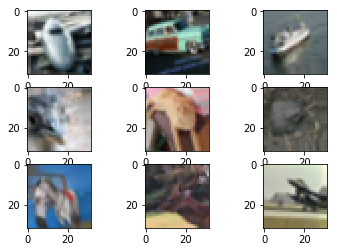

In [30]:
#show images after augmentation

for X_batch, y_batch in imggen.flow(X_train, Y_train, batch_size=9):
  
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow((X_batch[i]*255).astype(np.uint8).reshape(32, 32, 3),
              interpolation='none')
	plt.show()
	break

In [0]:
#implement learning rate scheduler

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003        
    return lrate

In [0]:
#finalize the functional model with the chosen parameters
from keras.models import Model
from keras.callbacks import LearningRateScheduler
from keras.layers import Input

K.clear_session()

weight_decay = 1e-4

inputs = Input(shape=input_shape)

x = Conv2D(32, (3,3), activation='elu', 
          kernel_regularizer=regularizers.l2(weight_decay),
          padding='same')(inputs)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), activation='elu',
          kernel_regularizer=regularizers.l2(weight_decay),
          padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.5)(x)

x = Conv2D(64, (3,3), activation='elu',
          kernel_regularizer=regularizers.l2(weight_decay),
          padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3,3), activation='elu',
          kernel_regularizer=regularizers.l2(weight_decay),
          padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.5)(x)

x = Conv2D(128, (3,3), activation='elu',
          kernel_regularizer=regularizers.l2(weight_decay),
          padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3,3), activation='elu',
          kernel_regularizer=regularizers.l2(weight_decay),
          padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
outputs = Dense(num_classes, activation='softmax')(x)

mdl = Model(inputs, outputs)

mdl.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [49]:
batch_size = 64

hist = mdl.fit_generator(
    imggen.flow(X_train, Y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=120, verbose=1, validation_data=(X_test, Y_test),
    callbacks=[LearningRateScheduler(lr_schedule),
              EarlyStopping(monitor='val_acc', mode='max', patience=5)])

Epoch 1/120
781/781 [==============================] - 27s 34ms/step - loss: 2.0943 - acc: 0.3673 - val_loss: 1.8592 - val_acc: 0.4222
Epoch 2/120
781/781 [==============================] - 24s 31ms/step - loss: 1.5010 - acc: 0.5026 - val_loss: 1.4627 - val_acc: 0.5396
Epoch 3/120
781/781 [==============================] - 24s 31ms/step - loss: 1.2670 - acc: 0.5722 - val_loss: 1.2294 - val_acc: 0.6079
Epoch 4/120
781/781 [==============================] - 24s 31ms/step - loss: 1.1442 - acc: 0.6178 - val_loss: 1.0329 - val_acc: 0.6663
Epoch 5/120
781/781 [==============================] - 24s 31ms/step - loss: 1.0618 - acc: 0.6487 - val_loss: 1.3684 - val_acc: 0.6033
Epoch 6/120
781/781 [==============================] - 24s 31ms/step - loss: 1.0024 - acc: 0.6751 - val_loss: 0.9625 - val_acc: 0.7075
Epoch 7/120
781/781 [==============================] - 24s 31ms/step - loss: 0.9743 - acc: 0.6865 - val_loss: 0.8503 - val_acc: 0.7384
Epoch 8/120
781/781 [==============================] - 

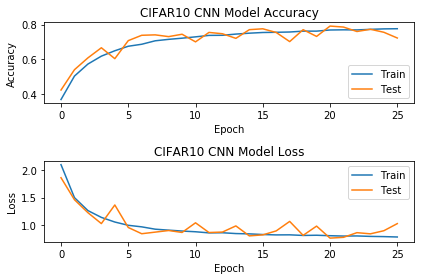

In [50]:
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('CIFAR10 CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('CIFAR10 CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout();

###Conclusion:
Data augmentation in this case didn't help with improvement much and learning rate scheduler didn't even kick in.
And the model was underperformed than the one prior to the tuning.
I created another experiment model using rmsprop optimizer with a different weight decay, and with augmentation reached 88.88% accuracy score on test set.

Given more time and higher computing power, I believe with increased number of layers (deeper network) and the better tuning options, the model can perform better on the task.